<a href="https://colab.research.google.com/github/leylamemiguven/digiturk-sentiment-analysis/blob/main/Sequential_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import models 
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, save_model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils import resample


import warnings
warnings.filterwarnings('ignore')

Reading CSV File

In [ ]:
df = pd.read_csv ('/content/drive/My Drive/downsamples.csv',sep=',')
#drop the wrong number column
del df['Unnamed: 0']
df

,text,sentiment
0,rt abvobekk passolig alan ben taraftar bin bir...,0
1,rt haberallan digitürk üyeliği olan kişi iptal...,0
2,digiturk sporun yıldızı paketine üye olmadan m...,0
3,rt celepgs olası bir yabancı sınırı kısıtlamas...,0
4,rt gripolar digitürk iptali arayan behzat uygu...,0
...,...,...
2695,teşekkürler digiturk devamını bekliyoruz digit...,1
2696,iyi digitürk almışım diyorum yaz akşamları fil...,1
2697,digitürk digiturkdestek yıllık digitürk abonel...,1
2698,yine babam oğlum izleyip aralıksız ağladım teş...,1


In [ ]:
tweets = df['text']
sentiments = df['sentiment']

0    1852
1     848
Name: sentiment, dtype: int64

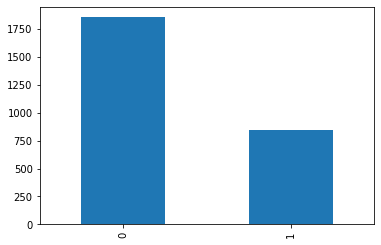

In [ ]:
sentiment_count = sentiments.value_counts()
sentiment_count.plot(kind="bar")
sentiments.value_counts()

Cleaning Data


In [ ]:
PUNCTUATIONS = r'''!()-[]{};:'"\,<>./?@#$%^&*_~'''
NUMBERS = '1234567890'

tweets_split = []
for i in range(len(df)):
  
  if df.iloc[i,0] is not None:
    for char in PUNCTUATIONS:
      for num in NUMBERS:
        if char in df.iloc[i,0] and num in df.iloc[i,0]:
          df.iloc[i,0] = df.iloc[i,0].replace(char,'').lower()
  tweets_split.append(df.iloc[i,0])

In [ ]:
df


,text,sentiment
0,rt abvobekk passolig alan ben taraftar bin bir...,0
1,rt haberallan digitürk üyeliği olan kişi iptal...,0
2,digiturk sporun yıldızı paketine üye olmadan m...,0
3,rt celepgs olası bir yabancı sınırı kısıtlamas...,0
4,rt gripolar digitürk iptali arayan behzat uygu...,0
...,...,...
2695,teşekkürler digiturk devamını bekliyoruz digit...,1
2696,iyi digitürk almışım diyorum yaz akşamları fil...,1
2697,digitürk digiturkdestek yıllık digitürk abonel...,1
2698,yine babam oğlum izleyip aralıksız ağladım teş...,1


Building LSTM Model

In [ ]:

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 30
# This is fixed.
EMBEDDING_DIM = 100

In [ ]:
## Tokenizing and checking the shapes of tensor(for testing purposes)
tk = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
tk.fit_on_texts(tweets_split)
X = tk.texts_to_sequences(tweets_split)
# print(X[0])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df['sentiment']).values
print('Shape of DM_Score tensor:', Y.shape)

Shape of data tensor: (2700, 30)
Shape of DM_Score tensor: (2700, 2)


In [ ]:
## Splitting data set into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=df[['sentiment']], test_size=0.15, random_state=42)   

## Checking the shape of the train and test set(For testing purposes) 

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

print("input length is  :", X.shape[1])

(2295, 30) (2295, 2)
(405, 30) (405, 2)
input length is  : 30


In [ ]:
## Generating model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           100000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 466,082
Trainable params: 466,082
Non-trainable params: 0
_________________________________________________________________
None


Training Model

In [ ]:


epochs = 10
batch_size = 16

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Epoch 1/10
130/130 [==============================] - 26s 200ms/step - loss: 0.4945 - accuracy: 0.7734 - val_loss: 0.3954 - val_accuracy: 0.8217
Epoch 2/10
130/130 [==============================] - 26s 199ms/step - loss: 0.2767 - accuracy: 0.8809 - val_loss: 0.3999 - val_accuracy: 0.8217
Epoch 3/10
130/130 [==============================] - 26s 198ms/step - loss: 0.2273 - accuracy: 0.9012 - val_loss: 0.3956 - val_accuracy: 0.8217
Epoch 4/10
130/130 [==============================] - 26s 197ms/step - loss: 0.1874 - accuracy: 0.9230 - val_loss: 0.4556 - val_accuracy: 0.8304
Epoch 5/10
130/130 [==============================] - 26s 200ms/step - loss: 0.1658 - accuracy: 0.9375 - val_loss: 0.4793 - val_accuracy: 0.8304
Epoch 6/10
130/130 [==============================] - 26s 198ms/step - loss: 0.1556 - accuracy: 0.9366 - val_loss: 0.4695 - val_accuracy: 0.8217
Epoch 7/10
130/130 [==============================] - 26s 199ms/step - loss: 0.1348 - accuracy: 0.9443 - val_loss: 0.5436 - val_ac

Text(0.5, 0, 'epoch')

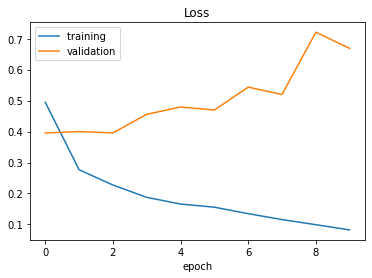

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training ', 'validation'])
plt.title("Loss")
plt.xlabel('epoch')

Sample Predictions

In [ ]:

# liste =['sikeyim sizin yapacaginiz isi digiturk ']
liste =['digiturk cok seviyoruz ailecek izliyoruz ']
# liste =['digiturk ne berabat sey']
# liste =['digiturk ne guzel goller gosteriyor ']
# liste =['digiturk hirizsiniz cebimden para caliyosunuz']

tk.fit_on_texts(liste)
X = tk.texts_to_sequences(liste)
# print(X)


X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
result = model.predict(X, batch_size=1)
print(result)

if result.item(0)> result.item(1):
  print('The tweet you typed is negative with ' + str(result.item(0)) +' probability')
else:
  print('The tweet you typed is positive with ' + str(result.item(1)) +' probability')


[[0.01987767 0.97964203]]
The tweet you typed is positive with 0.9796420335769653 probability


Saving Model to a .h5 file

In [ ]:

model.save("twitter_sentiment_analysis.h5")
print("Saved model to disk")


Saved model to disk


Converting .h5 model to pkl
